# 2. MLP from Scratch

In [1]:
import time
import math
import random

import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torch.utils import data
from torchvision import transforms

## Helper Functions

In [12]:
class Accumulator: 

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [92]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    '''
    Function to visualize the images.
    '''
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])#
    plt.show()

## Import Data

In [2]:
def get_fashion_mnist_labels(labels):
    '''
    Function to obtain the text label for each data point.
    '''
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [3]:
def load_data(batch_size, resize=None):
    '''
    Function to create a data iterator.
    '''
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root='../data', train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root='../data', train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=4))

In [45]:
batch_size = 256
train_iter, test_iter = load_data(batch_size)

## Initializing Parameters

In [80]:
num_inputs, num_hiddens, num_outputs = 784, 256, 10

W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

## Activation Function

In [81]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

## Model

In [82]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)
    O = H@W2 + b2
    return O

## Loss Function

In [83]:
loss = nn.CrossEntropyLoss(reduction='none')

## Optimizer

In [84]:
lr = 0.1
updater = torch.optim.SGD(params, lr=lr)

## Evaluation

In [85]:
def accuracy(y_hat, y):
    '''
    Count the number of correctly predicted samples.
    '''
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) 
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [86]:
def evaluate_accuracy(net, data_iter):
    '''
    Cumulative evaluation over multiple mini-batches.
    '''
    if isinstance(net, torch.nn.Module):
        net.eval()  #set the model to evaluation mode
    metric = Accumulator(2)  #number of correct predictions and total predictions
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

## Training

In [87]:
def train_epoch(net, train_iter, loss, updater):
    '''
    Training for a single epoch.
    '''
    if isinstance(net, torch.nn.Module):
        net.train()   
    metric = Accumulator(3)      #training loss, training accuracy, sample size
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat,y), y.numel())
    return metric[0]/metric[2], metric[1]/metric[2]

In [88]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        print(f'Epoch {epoch+1}')
        print(f'Training loss: {train_metrics[0]}')
        print(f'Training accuracy: {train_metrics[1]}')
        print(f'Test accuracy: {test_acc}')
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [89]:
num_epochs = 10
train(net, train_iter, test_iter, loss, num_epochs, updater)

Epoch 1
Training loss: 1.044340249379476
Training accuracy: 0.643
Test accuracy: 0.7498
Epoch 2
Training loss: 0.5983321887334188
Training accuracy: 0.7910666666666667
Test accuracy: 0.7914
Epoch 3
Training loss: 0.5186732711791993
Training accuracy: 0.8204
Test accuracy: 0.796
Epoch 4
Training loss: 0.48125498402913414
Training accuracy: 0.83275
Test accuracy: 0.8275
Epoch 5
Training loss: 0.4525190199534098
Training accuracy: 0.8409666666666666
Test accuracy: 0.8191
Epoch 6
Training loss: 0.43666274070739747
Training accuracy: 0.8465833333333334
Test accuracy: 0.8387
Epoch 7
Training loss: 0.4176624126434326
Training accuracy: 0.85315
Test accuracy: 0.8389
Epoch 8
Training loss: 0.40159461924235024
Training accuracy: 0.8578333333333333
Test accuracy: 0.8283
Epoch 9
Training loss: 0.3909572860717773
Training accuracy: 0.8619
Test accuracy: 0.8472
Epoch 10
Training loss: 0.38100163904825846
Training accuracy: 0.86525
Test accuracy: 0.8547


## Make Predictions

In [90]:
def predict(net, test_iter, n=6):
    for X, y in test_iter:
        break
    y_hats = net(X).argmax(axis=1)
    predictions = get_fashion_mnist_labels(y_hats)
    labels = get_fashion_mnist_labels(y)
    titles = [label +'\n' + prediction for label, prediction in zip(labels, predictions)]
    show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

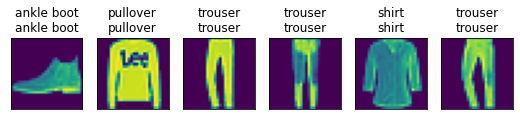

In [93]:
predict(net, test_iter)